<a href="https://colab.research.google.com/github/abuebayyeh/imperial_eee_machine_learning_course/blob/main/05_ML_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilayer Perceptron (MLP)


---


Multilayer perceptron (MLP) networks are one of the most commonly used networks, they are also considered as feed-forward networks. The development of the back-propagation learning algorithm for determining weights was the main reason behind the popularity of these networks among researchers. As the name suggests, an MLP consists of multiple perceptrons arranged into a number of layers in order to deal with complex problems. A typical MLP consists of an input layer, hidden layer(s) and an output layer. The units (neurons) in each layer are fully connected to the following layer. MLPs are usually described according to the number of neurons and layers used. For example, a 3-5-4 MLP is a two-layer network consisting of an input layer with three inputs, a hidden layer with five neurons and an output layer with four outputs. The figure below represent a 4-layer MLP (Note: the input layer is not counted as a layer).


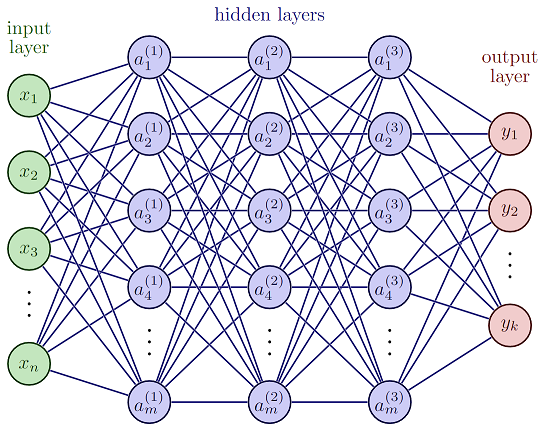

The feedforward operation is shown in the diagram below. Each neuron multiplies its inputs $a$ with corresponding weights $w$. The activation function $\theta$ is used to add non-linearity to the process and allows it to learn complex data sets (the network is equivalent to one linear transformation without these non-linearities - try to show this!). The activation function is applied after multiplying the weights with the inputs and summing the results.


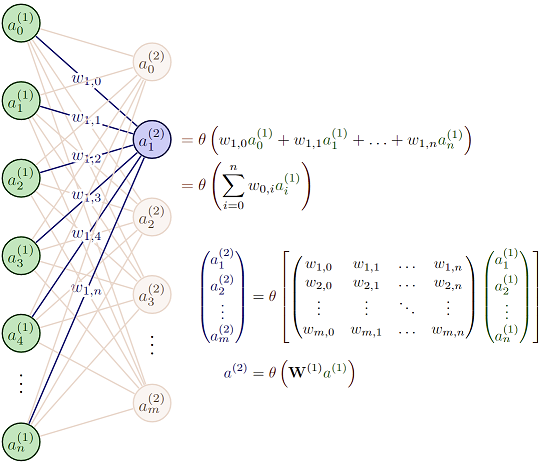

Many activation functions can be used in MLP depending on the problem being investigated. In the figure below are some examples of common activation functions.

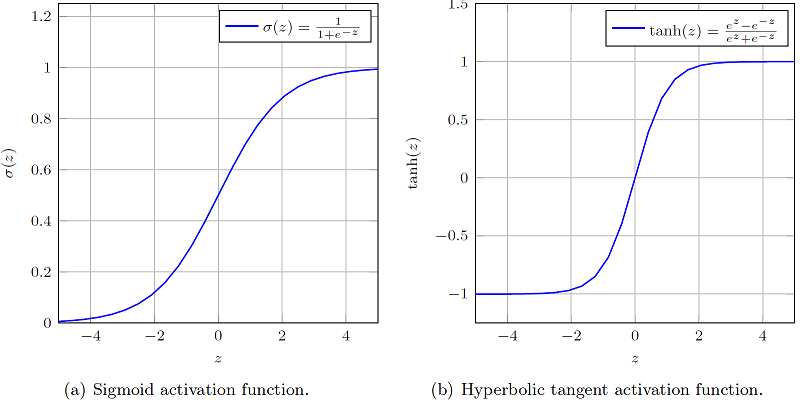

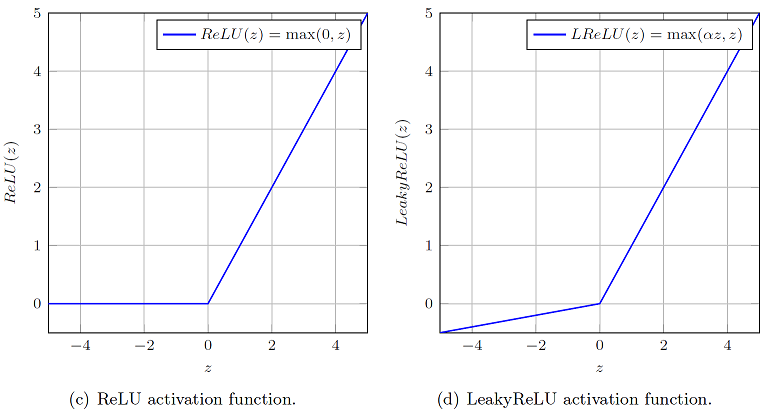

Many forms of cost functions $J$ to measure the error are available as mentioned in the previous tutorials. The objective of this process is to get the optimal set of tunable parameters (weights and biases) that will minimise the cost $J$. Back-propagation and gradient descent are used to apply these optimisation steps in a systematic manner such that the weights and biases are updated using the derivative and chain-rule concepts as described in the equations below.


\begin{aligned}
    \Delta w_i=-\alpha \frac{\partial J}{\partial w_i} \\
    w_{i}(t+1)=w_i(t)+\Delta w_i
\end{aligned}



The hyperparameter $\alpha$ is called the learning rate which is selected before the training takes place. If the value of $\alpha$ is too high, the algorithm may learn faster; however, it may diverge in reaching the minimal value resulting in oscillating behaviour. On the other hand, if the value of $\alpha$ is too small, the learning process will be slow but more stable. Parameter $t$ refers to the number of iterations (equivalent to number of epochs if update is calculated over entire dataset) where the weights are updated. At the start of training, the weights are usually given random values.






# MNIST Dataset

In this notebook, we will use a common open access dataset called Modified National Institute of Standards and Technology (MNIST) shown in Figure below.

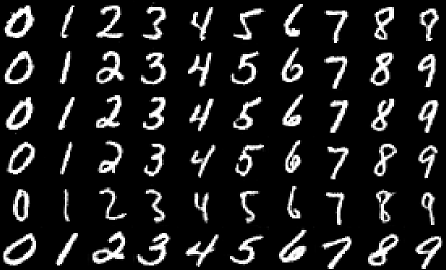


This data contains 70,000 scanned images of handwritten digits, together with their correct labels. These images are scanned handwriting samples from 250 people, half of whom were US Census Bureau employees, and the other half were high school students. The images are in grayscale format and of size $28\times 28$ pixels each. The labels are in integer format such that each image has the correct corresponding label that describes it as a number from 0 to 9. The MNIST data is divided into two parts. The first part is the training data that contains 60,000 images. The second part is the test data that contains 10,000 images.

## The code below is from "Python Machine Learning," Sebastian Raschka, Packt Publishing, 2015 (page 356), with modifications.

In [1]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the data from tensoflow library into train and test.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


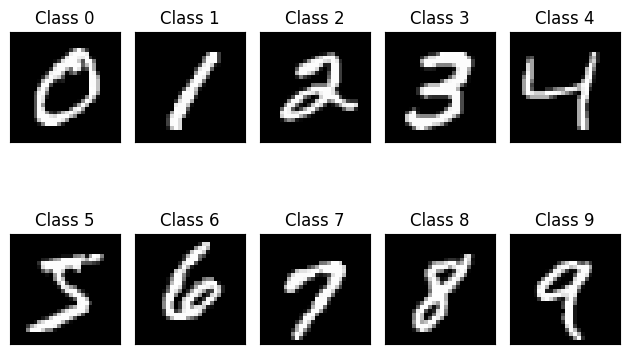

In [3]:
# Displaying samples of the 10 classes in this data

fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

Samples of class 3:


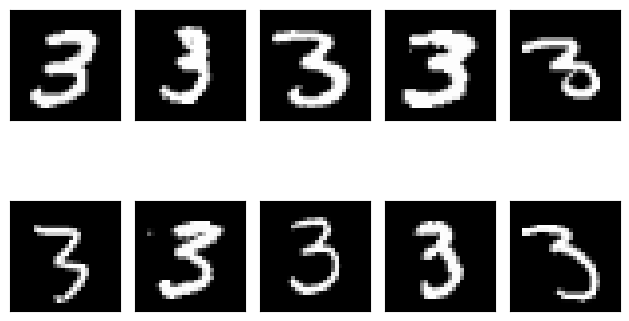

In [4]:
# Displaying different samples of the same class.
print("Samples of class 3:")
fig = plt.figure()

for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == 3]
    plt.imshow(x_y[i], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

Before the images are fed to the MLP, they should go through simple pre-processing steps. First, the pixel values are scaled (normalised) to have values between 0 and 1. In order to do that, all the pixel values are divided by 255 (MNIST grayscale images have 256 different gray values, numbered 0 - 255 (8 bits)). This improves learning stability. Secondly, the image should be flattened to a vector format as the MLP takes a vector with each input corresponding to a pixel location.

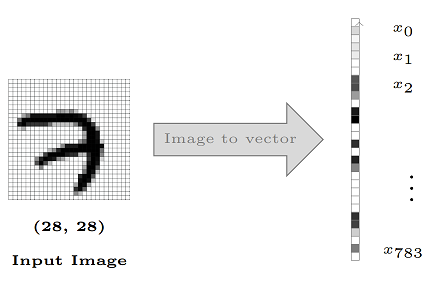

In [5]:
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
X_test = X_test.reshape(10000, 28*28)
# normalizing the inputs (-1, 1)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train.shape (60000, 28, 28)
X_test.shape (10000, 28, 28)
X_train reshape: (60000, 784)
X_test reshape: (10000, 784)


In [6]:
# Create a random permutation of indices
num_train_samples = len(X_train)
num_test_samples = len(X_test)

train_indices = np.random.permutation(num_train_samples)
test_indices = np.random.permutation(num_test_samples)

# Shuffle the data using the permutation of indices
X_train = X_train[train_indices]
y_train = y_train[train_indices]

X_test = X_test[test_indices]
y_test = y_test[test_indices]

The MNIST data does not include validation dataset; however, we can use part of the training set for validation as follows:

In [7]:
X_valid=X_train[:5000]
y_valid=y_train[:5000]
X_train=X_train[5000:60000]
y_train=y_train[5000:60000]


In [8]:
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    alpha : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, alpha=0.001,
                 shuffle=True, minibatch_size=1, seed=None,
                 activation="sigmoid"):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.alpha = alpha
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        if activation == "sigmoid":
            self.act = self._sigmoid
            self.act_deriv = lambda a_h: a_h * (1. - a_h)

        ##########################################################################
        #### Task 1:
        #### you can continue your code here to use different activation functions.
        #### adjust the previous conditional statments such that you add cases of
        #### other activation functions.
        ##########################################################################


    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_examples]
            Target values.
        n_classes : int
            Number of classes

        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self.act(z_h)

        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_examples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term

        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)

        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_examples]
            Target class labels.
        X_valid : array, shape = [n_examples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_examples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                act_derivative_h = self.act_deriv(a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           act_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.alpha * delta_w_h
                self.b_h -= self.alpha * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.alpha * delta_w_out
                self.b_out -= self.alpha * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)

            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            print('\r%0*d/%d | Cost: %.2f '
                  '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                  (epoch_strlen, i+1, self.epochs, cost,
                  train_acc*100, valid_acc*100))
            # sys.stderr.write
            # sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

===================================l2: 0================================
001/200 | Cost: 83629.16 | Train/Valid Acc.: 80.80%/80.72% 
002/200 | Cost: 59980.33 | Train/Valid Acc.: 86.20%/86.04% 
003/200 | Cost: 50081.10 | Train/Valid Acc.: 87.95%/87.76% 
004/200 | Cost: 44546.52 | Train/Valid Acc.: 89.06%/89.00% 
005/200 | Cost: 40970.64 | Train/Valid Acc.: 89.75%/89.62% 
006/200 | Cost: 38439.98 | Train/Valid Acc.: 90.18%/90.02% 
007/200 | Cost: 36460.69 | Train/Valid Acc.: 90.59%/90.20% 
008/200 | Cost: 34834.06 | Train/Valid Acc.: 90.99%/90.62% 
009/200 | Cost: 33536.35 | Train/Valid Acc.: 91.27%/90.84% 
010/200 | Cost: 32368.57 | Train/Valid Acc.: 91.59%/91.04% 
011/200 | Cost: 31308.77 | Train/Valid Acc.: 91.83%/91.22% 
012/200 | Cost: 30371.46 | Train/Valid Acc.: 92.12%/91.34% 
013/200 | Cost: 29482.75 | Train/Valid Acc.: 92.33%/91.62% 
014/200 | Cost: 28701.73 | Train/Valid Acc.: 92.55%/91.96% 
015/200 | Cost: 27911.97 | Train/Valid Acc.: 92.76%/92.14% 
016/200 | Cost: 27236.94 | 

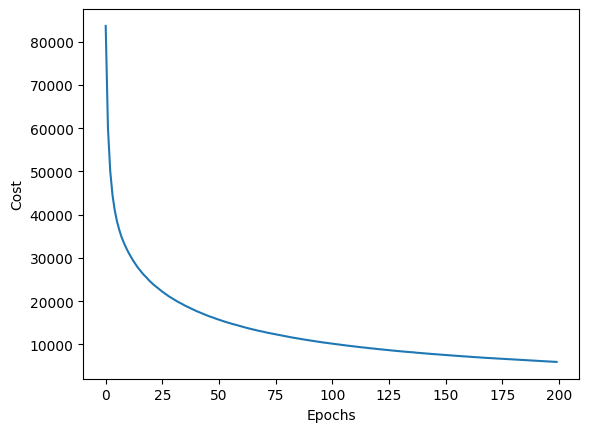

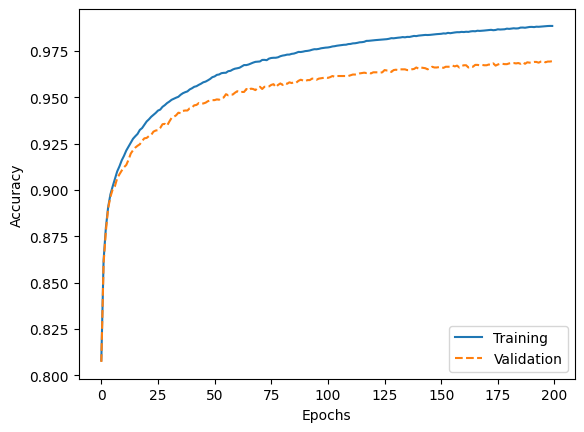

Test accuracy: 97.37%
Train accuracy: 98.84%
Val accuracy: 96.94%
===================================l2: 1================================
001/200 | Cost: 94032.04 | Train/Valid Acc.: 79.15%/79.20% 
002/200 | Cost: 73706.29 | Train/Valid Acc.: 84.92%/84.70% 
003/200 | Cost: 66452.71 | Train/Valid Acc.: 86.62%/86.22% 
004/200 | Cost: 62970.65 | Train/Valid Acc.: 87.48%/87.20% 
005/200 | Cost: 60992.76 | Train/Valid Acc.: 88.06%/87.96% 
006/200 | Cost: 59848.12 | Train/Valid Acc.: 87.95%/87.66% 
007/200 | Cost: 59074.81 | Train/Valid Acc.: 88.24%/87.78% 
008/200 | Cost: 58488.47 | Train/Valid Acc.: 88.35%/88.30% 
009/200 | Cost: 58237.09 | Train/Valid Acc.: 88.46%/88.12% 
010/200 | Cost: 58033.20 | Train/Valid Acc.: 88.61%/88.36% 
011/200 | Cost: 57760.97 | Train/Valid Acc.: 88.71%/88.56% 
012/200 | Cost: 57512.25 | Train/Valid Acc.: 88.68%/88.32% 
013/200 | Cost: 57415.64 | Train/Valid Acc.: 88.81%/88.64% 
014/200 | Cost: 57307.39 | Train/Valid Acc.: 88.58%/88.10% 
015/200 | Cost: 57078

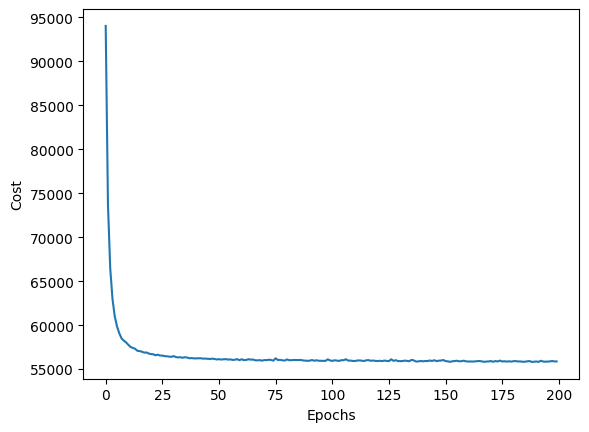

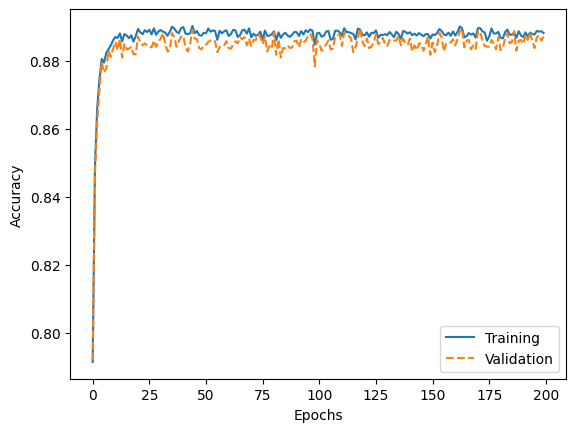

Test accuracy: 89.24%
Train accuracy: 88.82%
Val accuracy: 88.72%
===================================l2: 2================================
001/200 | Cost: 104366.12 | Train/Valid Acc.: 77.00%/76.70% 
002/200 | Cost: 87514.22 | Train/Valid Acc.: 82.61%/82.42% 
003/200 | Cost: 82538.54 | Train/Valid Acc.: 84.32%/84.10% 
004/200 | Cost: 80549.97 | Train/Valid Acc.: 85.13%/84.92% 
005/200 | Cost: 79447.24 | Train/Valid Acc.: 85.86%/85.88% 
006/200 | Cost: 78831.56 | Train/Valid Acc.: 85.15%/84.84% 
007/200 | Cost: 78380.17 | Train/Valid Acc.: 85.73%/85.82% 
008/200 | Cost: 77941.56 | Train/Valid Acc.: 85.86%/85.96% 
009/200 | Cost: 77862.90 | Train/Valid Acc.: 85.52%/85.24% 
010/200 | Cost: 77728.46 | Train/Valid Acc.: 86.23%/86.18% 
011/200 | Cost: 77497.47 | Train/Valid Acc.: 86.58%/86.46% 
012/200 | Cost: 77276.03 | Train/Valid Acc.: 86.29%/86.06% 
013/200 | Cost: 77264.12 | Train/Valid Acc.: 86.44%/86.54% 
014/200 | Cost: 77136.92 | Train/Valid Acc.: 85.36%/85.42% 
015/200 | Cost: 7688

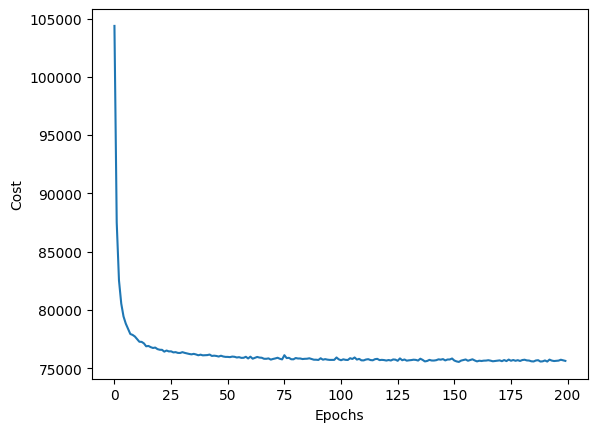

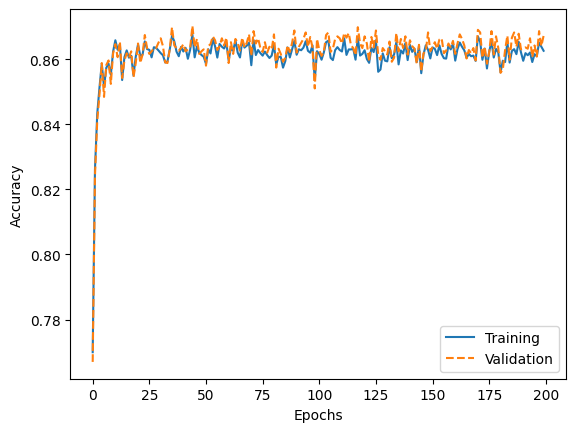

Test accuracy: 87.01%
Train accuracy: 86.26%
Val accuracy: 86.72%
===================================l2: 3================================
001/200 | Cost: 114450.07 | Train/Valid Acc.: 73.77%/73.84% 
002/200 | Cost: 100686.64 | Train/Valid Acc.: 79.33%/79.16% 
003/200 | Cost: 97041.93 | Train/Valid Acc.: 80.67%/80.36% 
004/200 | Cost: 95697.71 | Train/Valid Acc.: 81.05%/80.68% 
005/200 | Cost: 94967.49 | Train/Valid Acc.: 82.06%/81.84% 
006/200 | Cost: 94582.25 | Train/Valid Acc.: 80.28%/79.78% 
007/200 | Cost: 94331.38 | Train/Valid Acc.: 81.84%/81.76% 
008/200 | Cost: 94001.84 | Train/Valid Acc.: 81.67%/81.70% 
009/200 | Cost: 94048.22 | Train/Valid Acc.: 79.42%/78.44% 
010/200 | Cost: 93955.90 | Train/Valid Acc.: 82.17%/81.94% 
011/200 | Cost: 93769.67 | Train/Valid Acc.: 83.66%/83.06% 
012/200 | Cost: 93588.67 | Train/Valid Acc.: 82.65%/82.04% 
013/200 | Cost: 93653.91 | Train/Valid Acc.: 82.74%/82.66% 
014/200 | Cost: 93489.54 | Train/Valid Acc.: 78.98%/79.08% 
015/200 | Cost: 932

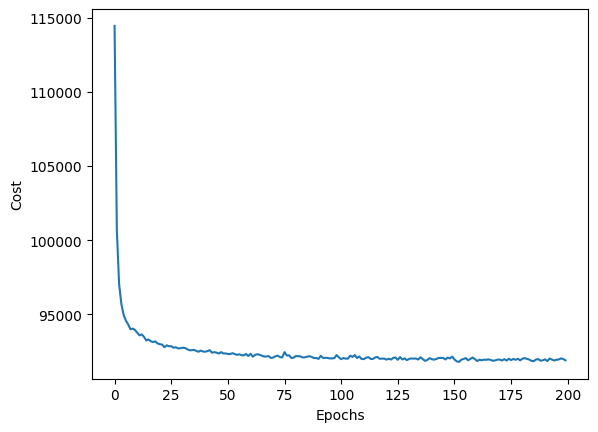

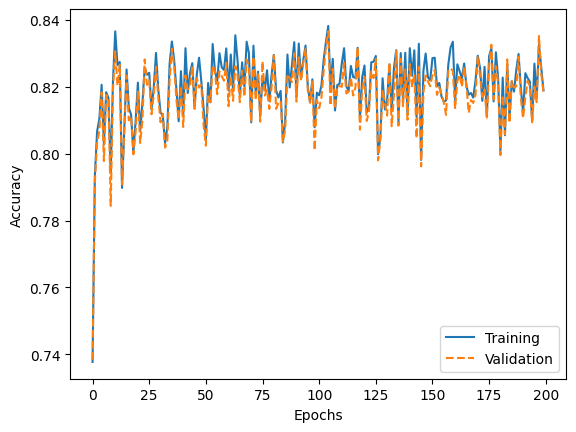

Test accuracy: 82.87%
Train accuracy: 81.90%
Val accuracy: 81.84%
===================================l2: 4================================
001/200 | Cost: 124094.72 | Train/Valid Acc.: 69.93%/70.06% 
002/200 | Cost: 112966.13 | Train/Valid Acc.: 75.15%/75.04% 
003/200 | Cost: 110250.77 | Train/Valid Acc.: 76.37%/76.24% 
004/200 | Cost: 109167.24 | Train/Valid Acc.: 76.69%/76.48% 
005/200 | Cost: 108504.22 | Train/Valid Acc.: 78.25%/77.84% 
006/200 | Cost: 108093.10 | Train/Valid Acc.: 75.17%/75.06% 
007/200 | Cost: 107857.00 | Train/Valid Acc.: 77.46%/76.98% 
008/200 | Cost: 107515.78 | Train/Valid Acc.: 77.09%/76.78% 
009/200 | Cost: 107572.88 | Train/Valid Acc.: 74.40%/73.62% 
010/200 | Cost: 107453.82 | Train/Valid Acc.: 77.68%/76.86% 
011/200 | Cost: 107262.94 | Train/Valid Acc.: 80.00%/79.32% 
012/200 | Cost: 107094.59 | Train/Valid Acc.: 78.17%/77.56% 
013/200 | Cost: 107195.42 | Train/Valid Acc.: 78.23%/78.06% 
014/200 | Cost: 106969.58 | Train/Valid Acc.: 73.19%/72.88% 
015/200

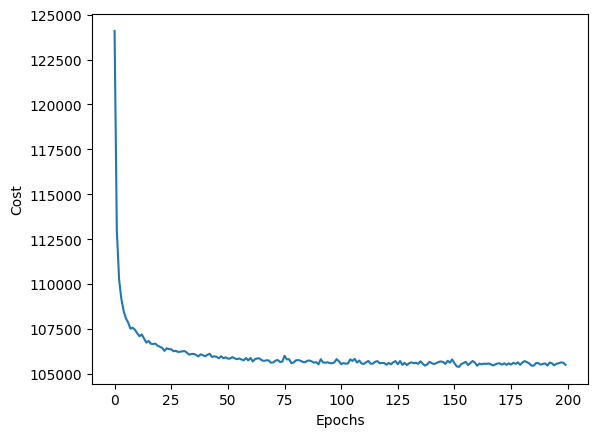

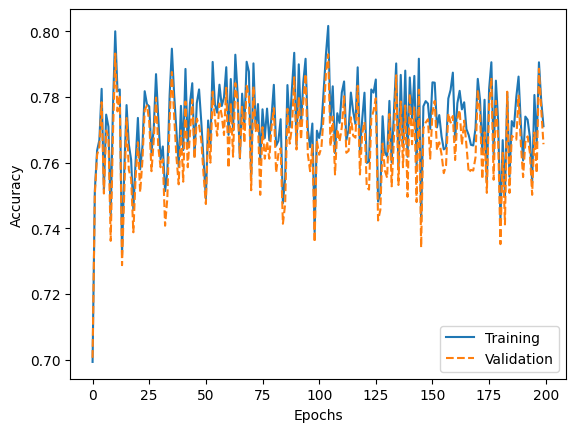

Test accuracy: 77.96%
Train accuracy: 77.11%
Val accuracy: 76.56%


In [12]:
# Executing the algorithm here (it may take some time to execute the code)

n_epochs = 200 # Number of training epochs

for l2i in range(5):
       print('===================================l2: '+str(l2i)+'================================')
       # Initialize a NeuralNet MLP
       nn = NeuralNetMLP(
       n_hidden=100,
       l2=l2i,
       epochs=n_epochs,
       alpha=0.0005,
       minibatch_size=100,
       shuffle=True,
       seed=1,
       activation="sigmoid"
       )

       # Here we use part of the training data for validation such that 55000 data samples for training and the rest 5000
       #for validation
       nn.fit(
       X_train,
       y_train,
       X_valid,
       y_valid
       )

       # plot the cost vs epochs
       plt.plot(range(nn.epochs), nn.eval_['cost'])
       plt.ylabel('Cost')
       plt.xlabel('Epochs')
       plt.show()

       plt.plot(range(nn.epochs), nn.eval_['train_acc'],
              label='Training')
       plt.plot(range(nn.epochs), nn.eval_['valid_acc'],
              label='Validation', linestyle='--')
       plt.ylabel('Accuracy')
       plt.xlabel('Epochs')
       plt.legend(loc='lower right')
       plt.show()

       y_test_pred = nn.predict(X_test)
       acc = (np.sum(y_test == y_test_pred)
              .astype(np.float) / X_test.shape[0])

       print('Test accuracy: %.2f%%' % (acc * 100))

       y_train_pred = nn.predict(X_train)
       acc = (np.sum(y_train == y_train_pred)
              .astype(np.float) / X_train.shape[0])

       print('Train accuracy: %.2f%%' % (acc * 100))

       y_val_pred = nn.predict(X_valid)
       acc = (np.sum(y_valid == y_val_pred)
              .astype(np.float) / X_valid.shape[0])

       print('Val accuracy: %.2f%%' % (acc * 100))

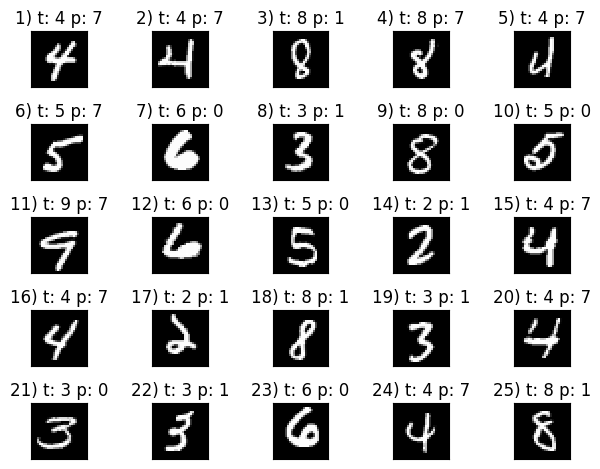

In [10]:
# Plot examples of misclassified images
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='gray', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Task 1 [60 marks]

### Part A: Optimize L2 Regularization

In the provided code, an L2 regularization parameter, `l2`, was set to 10. Your task is to find the optimal value for `l2` that can improve the model's performance. After selecting the optimal `l2` value, report the following accuracies:
- Training accuracy
- Validation accuracy
- Test accuracy

Discuss in your report why these accuracies changed significantly when you experimented with different `l2` values. Hint: Try lower values of `l2`.

### Part B: Explore Activation Functions

Modify the code to use different activation functions in the hidden layer, specifically `tanh` and `relu`. Keep the output layer activation function as `sigmoid` since the output needs to be in the range 0-1 for cross-entropy loss calculation. Use the previously optimized `l2` value for this part. Report the effects of using these activation functions on the training, validation, and test accuracies.

Please provide detailed explanations of the observed changes in accuracy and any insights you gain from these experiments.


## Task 2 [40 marks]

For this task, use the optimized `l2` value obtained from Task 1 and the `sigmoid` activation function for your model. This task focuses on evaluating the model's performance and reporting various metrics.

### Part A: Confusion Matrix

Write code to display the confusion matrix of the test data. Include both the code and the generated figure in your report.

### Part B: Precision, Recall, and F1-Score Calculation

Write code to estimate precision, recall, and F1-score for the test data, considering each class separately. Include both the code and the results in your report.

Reminder: The formulas for these metrics are as follows:

- Accuracy:
  \begin{equation}
      Accuracy = \frac{TN + TP}{TN + TP + FN + FP}
  \end{equation}

- Precision:
  \begin{equation}
      Precision = \frac{TP}{TP + FP}
  \end{equation}

- Recall:
  \begin{equation}
      Recall = \frac{TP}{TP + FN}
  \end{equation}

- F1-Score:
  \begin{equation}
      F1\text{-}score = \frac{2 \cdot (Precision \cdot Recall)}{Precision + Recall}
  \end{equation}

Where:
- TN = True Negative
- TP = True Positive
- FN = False Negative
- FP = False Positive

For reference and a useful diagram, you can visit the Wikipedia page on [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall).

Please ensure you provide both the code and the calculated results in your report for a comprehensive evaluation of the model's performance.
